# Milestone #1

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
from skimage.color import rgb2gray
from skimage.transform import rotate
from skimage.transform import (hough_line, hough_line_peaks)
from scipy.stats import mode
from skimage import io
from skimage.filters import threshold_otsu, sobel
from matplotlib import cm
import cv2
from google.colab.patches import cv2_imshow
from math import sqrt

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving 08 - compresso espresso.jpg to 08 - compresso espresso.jpg


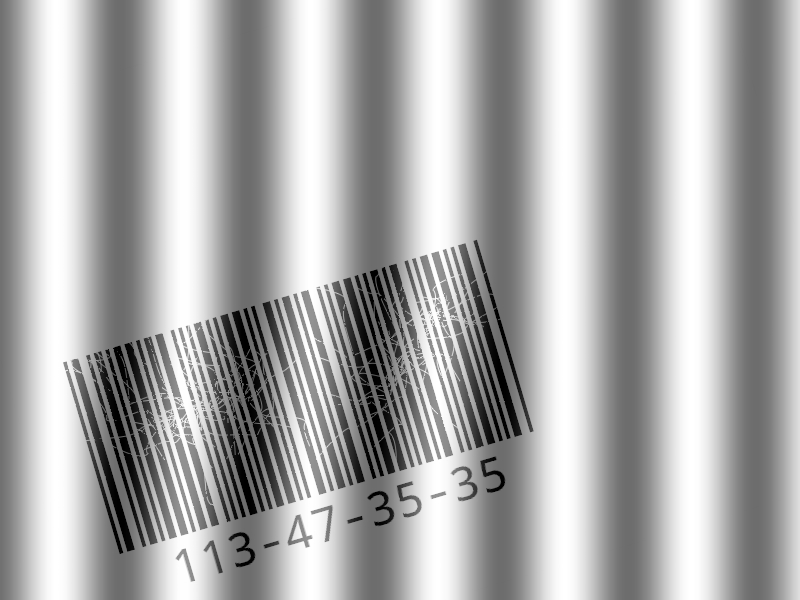

In [847]:
#reading the input test image
image_path = "/content/11 - bayza 5ales di bsara7a.jpg"
image = cv2.imread(image_path)
cv2_imshow(image)

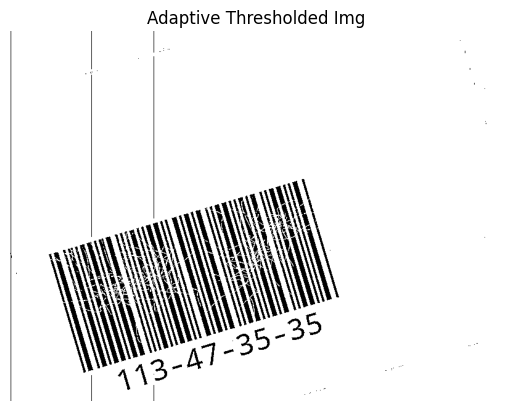

In [851]:
def adaptive_thresholding(image, block_size=15, C=2):
    # With blocksize 11 it removes the sin wave noise very well but ruins the rest so 13 or 15 is fine ig
    # Ensure the image is grayscale
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian adaptive thresholding
    thresholded_image = cv2.adaptiveThreshold(image, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              thresholdType=cv2.THRESH_BINARY,  blockSize=block_size, C=C)

    plt.imshow(thresholded_image, cmap='gray')
    plt.title('Adaptive Thresholded Img')
    plt.axis('off')
    plt.show()

    return thresholded_image


threshold1 = adaptive_thresholding(image)


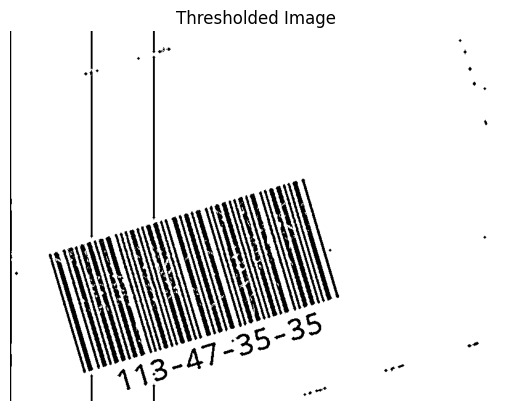

[[  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255 255 255]
 ...
 [  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255 255 255]
 [  0   0 255 ... 255 255 255]]


In [852]:

def preprocessing(image):
    # Apply Gaussian blur

    gaussian_blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply median blur
    median_blurred = cv2.medianBlur(gaussian_blurred, 5)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization) helpful in low contrast images
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(median_blurred)

    # Adaptive Thresholding
    thresholded = cv2.adaptiveThreshold(
        equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 1
    )

    plt.imshow(thresholded, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

    return thresholded


result = preprocessing(threshold1)
print(result)


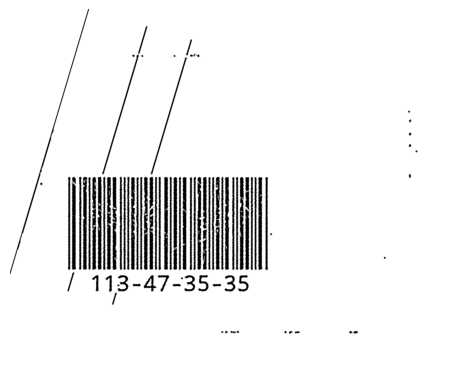

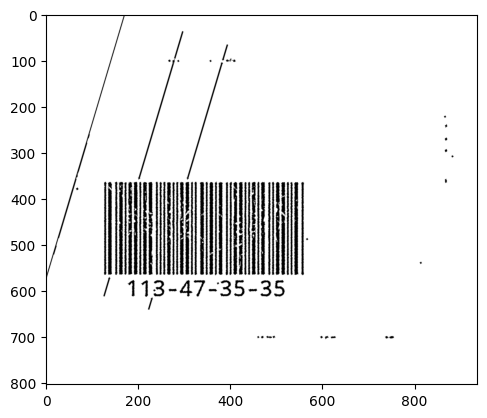

In [853]:

def rotated_barcode(image):
    # Detect edges using Canny edge detector
    edge_detected = cv2.Canny(image, 50, 150)

    # Get the contours from the edges
    contours_found, _ = cv2.findContours(edge_detected, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours_found:
        primary_contour = max(contours_found, key=cv2.contourArea)  # the largest contour by area
        rectangle = cv2.minAreaRect(primary_contour)  # Get the rotated rectangle that best fits the largest contour
        corner_points = cv2.boxPoints(rectangle)
        corner_points = np.int32(corner_points)

        # Compute the rotation angle of the bounding rectangle
        rotation_angle = rectangle[-1]
        if rotation_angle < -45:
            rotation_angle -= 90
        #print(rotation_angle)
        # Image dimensions and calculate the center for rotation

        img_height, img_width = image.shape[:2]
        rotation_center = (img_width // 2, img_height // 2)

        # Calculate the new width and height to avoid clipping after rotation
        new_width = int(img_width * np.abs(np.cos(np.radians(rotation_angle))) + img_height * np.abs(np.sin(np.radians(rotation_angle))))
        new_height = int(img_height * np.abs(np.cos(np.radians(rotation_angle))) + img_width * np.abs(np.sin(np.radians(rotation_angle))))

        # Rotation matrix based on the angle
        rotation_matrix = cv2.getRotationMatrix2D(rotation_center, rotation_angle, 1.0)
        rotation_matrix[0, 2] += (new_width - img_width) / 2  # Adjust the translation to center the rotated image
        rotation_matrix[1, 2] += (new_height - img_height) / 2

        # Rotate the image using the matrix and warpAffine
        rotated_image = cv2.warpAffine(image, rotation_matrix, (new_width, new_height),
                                        flags=cv2.INTER_LINEAR,
                                        borderMode=cv2.BORDER_CONSTANT,
                                        borderValue=(255, 255, 255))

        # Apply the rotation matrix to the corners of the rectangle
        rotated_box = np.int32(cv2.transform(np.array([corner_points]), rotation_matrix)[0])

        # Get the bounding box of the rotated rectangle
        x, y, rotated_height, rotated_width = cv2.boundingRect(rotated_box)

        # If the rotated height is greater than width, rotate the image 90 degrees clockwise
        if rotated_height > rotated_width:
            rotated_image = cv2.rotate(rotated_image, cv2.ROTATE_90_CLOCKWISE)

    plt.imshow(rotated_image, cmap='gray')
    plt.axis('off')
    plt.show()

    return rotated_image

result_image = rotated_barcode(result)  # Hnbasy el result from preprocessing
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('on')
plt.show()


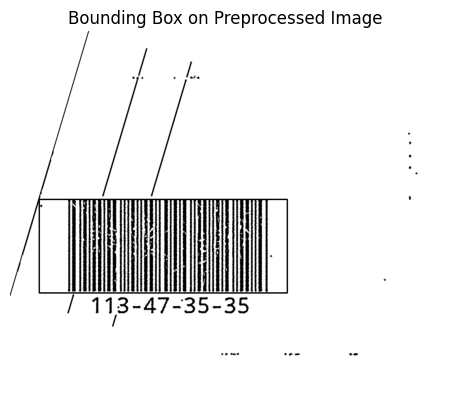

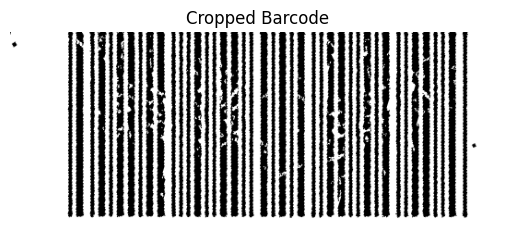

In [854]:
def crop_barcode(image_path):
    #binary threshold
    _, binary = cv2.threshold(image_path, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    # Finding contours again bs this time the external ones to crop on them
    #i could have used sobel (which i tried and its at the end of the code in a separate section so that u can see my trials) dh comment fl crop
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out vertical lines based on aspect ratio and position
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = h / w
        if aspect_ratio > 5 and x < binary.shape[1] * 0.1:
            cv2.drawContours(binary, [contour], -1, 0, -1)

    # Removing noise to ensure only the barcode is isolated
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)
    x, y, w, h = cv2.boundingRect(binary_cleaned)   # A tight bounding box around the barcode

    # Dynamically calculate TOLERANCE as a fraction of the barcode width,
    # I tried the constant tolerance with 40 and 60, it worked but was not sso generic so i came up with this
    TOLERANCE_LEFT = int(w * 0.15)  # 15% of the barcode width for left
    TOLERANCE_RIGHT = int(w * 0.1)  # 10% of the barcode width for right

    # Ensure coordinates are within image bounds
    x_start = max(0, x - TOLERANCE_LEFT)
    x_end = min(image_path.shape[1], x + w + TOLERANCE_RIGHT)
    test_image = image_path.copy()
    cv2.rectangle(test_image, (x_start, y), (x_end, y + h), (0, 255, 0), 2)


    plt.imshow(cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Bounding Box on Preprocessed Image")
    plt.show()

    cropped = image_path[y:y + h, x_start:x_end]

    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Cropped Barcode")
    plt.show()

    return cropped

cropped = crop_barcode(result_image)


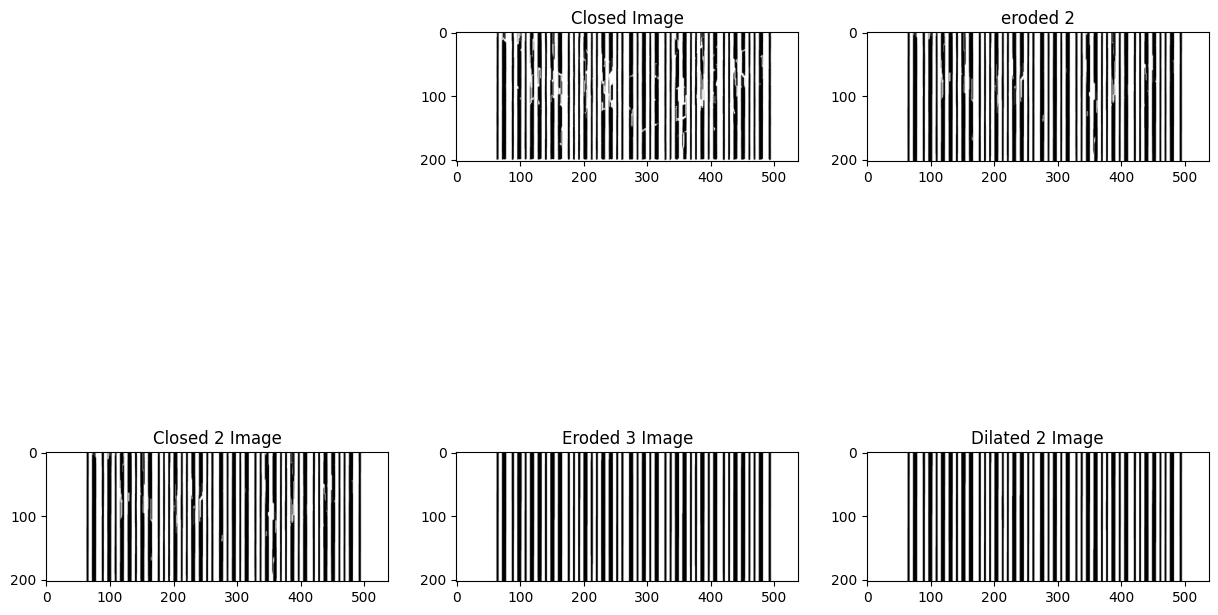

In [855]:
# Normalize cropped image for morphological operations
image_normalized = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 17))

# Opening (erosion followed by dilation)
#opened = cv2.morphologyEx(image_normalized, cv2.MORPH_OPEN, kernel)

# Closing (dilation followed by erosion)

# Erosion
#eroded = cv2.erode(image_normalized, kernel, iterations=1)

# Dilation (to refine barcode further)
#dilated = cv2.dilate(image_normalized, kernel, iterations=1)
#dilated2=cv2.dilate(dilated, kernel, iterations=1)
#eroded2 = cv2.erode(dilated, kernel, iterations=1)
#eroded3=cv2.erode(eroded2, kernel, iterations=1)
closed = cv2.morphologyEx(image_normalized, cv2.MORPH_CLOSE, kernel)
eroded2 = cv2.erode(closed, kernel, iterations=1)
closed2=cv2.morphologyEx(eroded2, cv2.MORPH_CLOSE, kernel)
#opened = cv2.morphologyEx(closed2, cv2.MORPH_OPEN, kernel)
eroded3=cv2.erode(closed2, kernel, iterations=7)
dilation2 =cv2.dilate(eroded3, kernel, iterations=7)
#open = cv2.morphologyEx(dilation2, cv2.MORPH_OPEN, kernel, iterations=3)

# Invert the image for better visibility
#inverted = cv2.bitwise_not(dilated)open = cv2.morphologyEx(dilation2, cv2.MORPH_OPEN, kernel, iterations=3)

# Plot all results
plt.figure(figsize=(15, 10))
#plt.subplot(2, 3, 6), plt.title("Opened Image"), plt.imshow(opened, cmap='gray')
plt.subplot(2, 3, 6), plt.title("Dilated 2 Image"), plt.imshow(dilation2, cmap='gray')
plt.subplot(2, 3, 2), plt.title("Closed Image"), plt.imshow(closed, cmap='gray')
plt.subplot(2, 3, 4), plt.title("Closed 2 Image"), plt.imshow(closed2, cmap='gray')
plt.subplot(2, 3, 5), plt.title("Eroded 3 Image"), plt.imshow(eroded3, cmap='gray')
#plt.subplot(2, 3, 1), plt.title("Dilated Image"), plt.imshow(dilated, cmap='gray')
plt.subplot(2, 3, 3), plt.title("eroded 2"), plt.imshow(eroded2, cmap='gray')
#plt.subplot(2, 3, 5), plt.title("Inverted Image"), plt.imshow(inverted, cmap='gray')
# plt.subplot(2, 3, 6), plt.title("Cropped Image"), plt.imshow(cropped, cmap='gray')
plt.show()

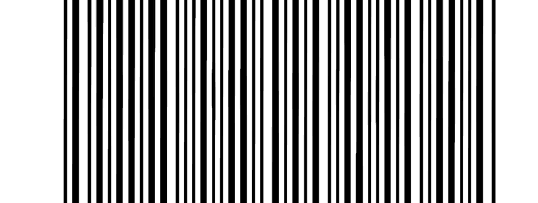

In [856]:
cv2_imshow(dilation2)

In [857]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# Get the average of each column in your image
mean = dilation2.mean(axis=0)

# Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Adjust the barcode a bit
adjusted_pixels = ""
pixel_index = 0

while pixel_index < len(pixels):
    count = 1
    try:
        while pixels[pixel_index] == pixels[pixel_index + 1]:
            count += 1
            pixel_index += 1
    except IndexError:
        pass

    if pixels[pixel_index] == "1":
        adjusted_width = 6 if count < 6 else 10  # Narrow = 6, Wide = 10 a3dt agrb bsraha lhd ma zbtt shwaya
        adjusted_pixels += "1" * adjusted_width
    else:
        adjusted_width = 6 if count < 8 else 10
        adjusted_pixels += "0" * adjusted_width

    pixel_index += 1

# Convert adjusted pixels back to an image
adjusted_image = np.full((dilation2.shape[0], len(adjusted_pixels)), 255, dtype=np.uint8)
for col_index, pixel in enumerate(adjusted_pixels):
    if pixel == "1":
        adjusted_image[:, col_index] = 0



mean = adjusted_image.mean(axis=0)

mean[mean <= 127] = 1
mean[mean > 128] = 0

pixels = ''.join(mean.astype(np.uint8).astype(str))

# Skip leading white spaces
first_black_index = pixels.find('1')
if first_black_index == -1:
    print("no black bars")
    decoded_data = []
else:
    pixels = pixels[first_black_index:]  # Trim leading white spaces
    print(f"pixels: {pixels}")


# Need to figure out how many pixels represent a narrow bar
    narrow_bar_size = 0
    narrow_white_bar_size = 0
    white = 0
    for pixel in pixels:
        if pixel == "1" and white == 0:
            narrow_bar_size += 1
        elif pixel == "0":
            narrow_white_bar_size += 1
            white = 1
        else:
            break
    print(f"narrow bar size: {narrow_bar_size}")
    print(f"narrow wide bar size: {narrow_white_bar_size}")

    # Define wide bar size as twice the narrow bar size
    wide_bar_size = narrow_bar_size * 2
    wide_white_bar_size = narrow_white_bar_size * 2
    print(f"wide bar size: {wide_bar_size}")
    print(f"wide widee bar size: {wide_white_bar_size}")

    digits = []
    pixel_index = 0
    current_digit_widths = ""
    skip_next = False

    while pixel_index < len(pixels):
        if skip_next:
            pixel_index += narrow_white_bar_size
            skip_next = False
            continue

        count = 1
        try:
            while pixels[pixel_index] == pixels[pixel_index + 1]:
                count += 1
                pixel_index += 1
        except IndexError:
            pass
        pixel_index += 1

        current_digit_widths += NARROW if (count <= narrow_bar_size or count <= narrow_white_bar_size) else WIDE

        if current_digit_widths in code11_widths:
            digits.append(code11_widths[current_digit_widths])
            print(f"pixel: {pixel_index}, matches with: {code11_widths[current_digit_widths]}")
            current_digit_widths = ""
            skip_next = True  # Next iteration will be a separator, so skip it

    decoded_data = digits

print("Decoded Barcode:", decoded_data)


pixels: 11111100000011111111110000000000111111000000111111111100000011111100000011111111110000001111111111000000111111000000111111111100000011111111110000000000111111000000111111000000111111000000111111111100000011111100000011111100000011111111110000001111111111000000111111000000111111000000000011111111110000001111110000001111111111000000111111000000111111111100000000001111110000001111110000001111111111000000111111111100000011111100000011111100000011111111110000001111110000001111111111000000000011111100000011111100000011111111110000001111111111000000111111000000111111000000111111111100000000001111110000000000
narrow bar size: 6
narrow wide bar size: 6
wide bar size: 12
wide widee bar size: 12
pixel: 38, matches with: Stop/Start
pixel: 82, matches with: 1
pixel: 126, matches with: 1
pixel: 170, matches with: 3
pixel: 210, matches with: -
pixel: 254, matches with: 4
pixel: 298, matches with: 7
pixel: 338, matches with: -
pixel: 382, matches with: 3
pixel: 426, matches with: 5
pixel: 466,

# Useless code, My failed trials :V

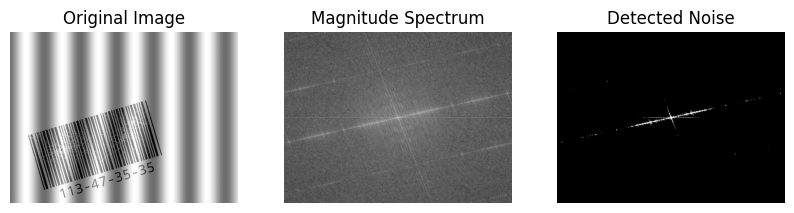

Frequency noise detected!


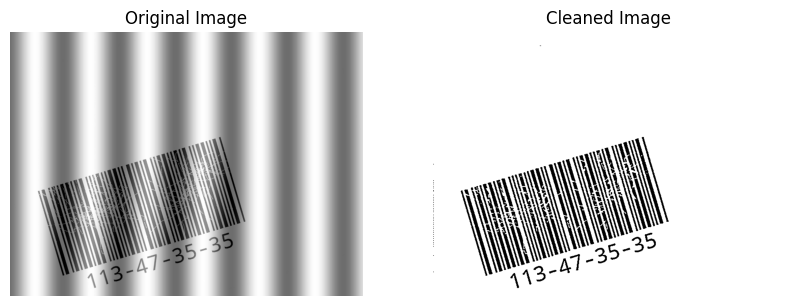

In [ ]:
#i tried to detect the freq noise, and then remove it w kda, it worked very well with test img number 11
#but it detects noises in the rest of the test images, i guess its because of the threshold value,
#i tried to adjust it bas unfortunately, i failed :((((
import numpy as np
import cv2
import matplotlib.pyplot as plt

def detect_frequency_noise(image):

    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image


    dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shift = np.fft.fftshift(dft)

    # Calculate magnitude spectrum
    magnitude_spectrum = cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1])
    magnitude_log = np.log(1 + magnitude_spectrum)

    # Normalization
    magnitude_normalized = cv2.normalize(magnitude_log, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Thresholding to detect significant peaks
    _, binary = cv2.threshold(magnitude_normalized, 150, 255, cv2.THRESH_BINARY)

    # Count non-zero points (the noise indicators)
    noise_points = cv2.countNonZero(binary)

    # Define a threshold for noise detection
    noise_threshold = 100  # I tried to adjust this value , but as i said i cant find a sol.
    has_noise = noise_points > noise_threshold


    plt.figure(figsize=(10, 5))
    plt.subplot(1, 3, 1), plt.title("Original Image"), plt.imshow(gray, cmap='gray'), plt.axis('off')
    plt.subplot(1, 3, 2), plt.title("Magnitude Spectrum"), plt.imshow(magnitude_normalized, cmap='gray'), plt.axis('off')
    plt.subplot(1, 3, 3), plt.title("Detected Noise"), plt.imshow(binary, cmap='gray'), plt.axis('off')
    plt.show()

    return has_noise

def remove_freq_noise(image):

    if not detect_frequency_noise(image):
        print("No significant frequency noise detected. Skipping noise removal.")
        return image  # Return the original image unchanged (this was supposed to return the images that doesnt have noises)
        #BUT IDK WHYYYY IT DOESNT WORK :( , it works with some images tho like (compresso espresso & wen el kontrast)

    print("Frequency noise detected!")

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply adaptive histogram equalization
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(gray)

    denoised = cv2.GaussianBlur(equalized, (5, 5), 0)

    # Apply adaptive thresholding
    binary = cv2.adaptiveThreshold(denoised, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)


    kernel = np.ones((1, 3), np.uint8)
    enhanced = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1), plt.title("Original Image"), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)), plt.axis('off')
    plt.subplot(1, 2, 2), plt.title("Cleaned Image"), plt.imshow(enhanced, cmap='gray'), plt.axis('off')
    plt.show()

    return enhanced

image = cv2.imread("/content/11 - bayza 5ales di bsara7a.jpg")
cleaned_image = remove_freq_noise(image)


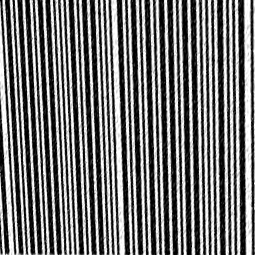

In [ ]:
#this is another method for rotation, but it is not generic, thankfully i was able to find a generic one
#but this method was interesting tho
import cv2
import numpy as np
from google.colab.patches import cv2_imshow

def detect_and_rotate_with_perspective(image):

    if image is None or not hasattr(image, "shape"):
        raise ValueError("Invalid image provided.")

    # Define source and destination points i got them from the paint app where i got each corners pixel
    pts1 = np.float32([[0, 156], [336, 0], [71, 342], [417, 156]])
    pts2 = np.float32([[0, 0], [255, 0], [0, 255], [255, 255]])

    #the transformation matrix
    matrix = cv2.getPerspectiveTransform(pts1, pts2)

    # Apply the perspective warp , this is used in rotation!
    final = cv2.warpPerspective(image, matrix, (255, 255))

    return final


image_path = '/content/09 - e3del el soora ya3ammm.jpg'
image = cv2.imread(image_path)


rotated_image = detect_and_rotate_with_perspective(image)


cv2_imshow(rotated_image)


<ipython-input-129-db75d1b97e3e>:35: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box = np.int0(box)


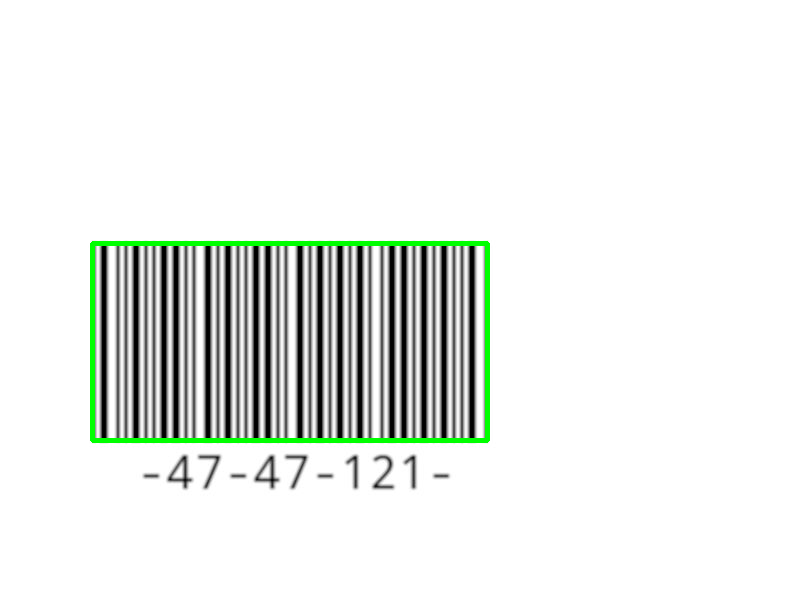

In [ ]:
#Sobel for cropping, it crops but it doesnt work on all of the images, since it cant always find the contours

import imutils
import numpy as np
import matplotlib.pyplot as plt
import cv2

image_path = "/content/04 - fen el nadara.jpg"
image = cv2.imread(image_path)

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
# compute the Scharr gradient magnitude representation of the images
# in both the x and y direction using OpenCV 2.4
ddepth = cv2.cv.CV_32F if imutils.is_cv2() else cv2.CV_32F
gradX = cv2.Sobel(gray, ddepth=ddepth, dx=1, dy=0, ksize=-1)
gradY = cv2.Sobel(gray, ddepth=ddepth, dx=0, dy=1, ksize=-1)
# subtract the y-gradient from the x-gradient
gradient = cv2.subtract(gradX, gradY)
gradient = cv2.convertScaleAbs(gradient)
# blur and threshold the image
blurred = cv2.blur(gradient, (9, 9))
(_, thresh) = cv2.threshold(blurred, 225, 255, cv2.THRESH_BINARY)
# construct a closing kernel and apply it to the thresholded image
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (21, 7))
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
# find the contours in the thresholded image, then sort the contours
# by their area, keeping only the largest one
cnts = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
# compute the rotated bounding box of the largest contour
rect = cv2.minAreaRect(c)
box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
box = np.int0(box)
# draw a bounding box arounded the detected barcode and display the
# image
image_contoured=image.copy()
cv2.drawContours(image_contoured, [box], -1, (0, 255, 0), 3)
cv2_imshow(image_contoured)


In [ ]:
((center_x,center_y),(w,h),angle)=rect
start_x=center_x-(w)
start_y=center_y-(h)
box

array([[ 92, 243],
       [487, 243],
       [487, 440],
       [ 92, 440]])

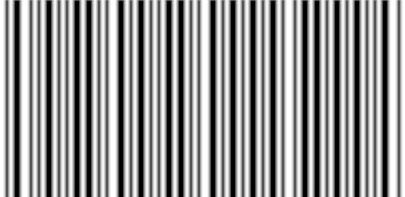

In [ ]:
#cv2_imshow(image)
debug_image=image.copy()
cropped = image[ box[0][1]:box[3][1],box[0][0]-5:box[1][0]+5]
cv2_imshow(cropped)

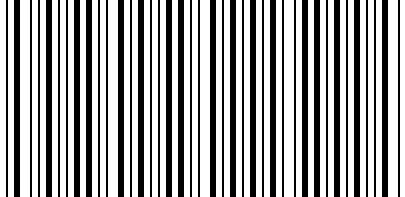

In [ ]:
gray_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
_, binary = cv2.threshold(gray_cropped, 0, 255,  cv2.THRESH_OTSU)
cv2_imshow(binary) #khosara wallahe enha msh shghala fl ba'y

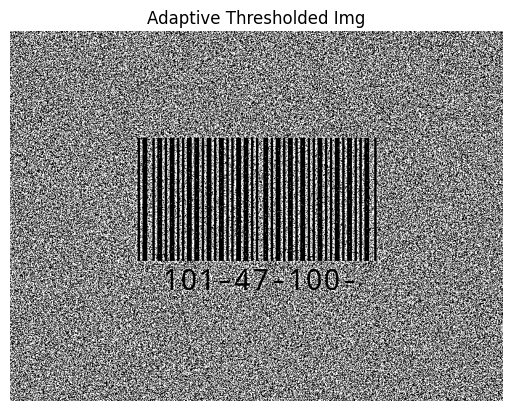

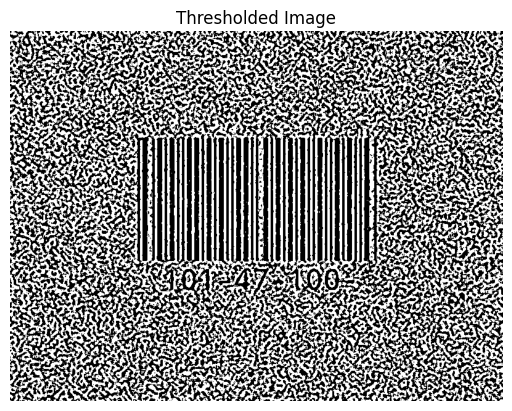

[[  0   0 255 ...   0   0   0]
 [  0   0   0 ...   0   0   0]
 [  0   0 255 ...   0   0   0]
 ...
 [  0   0   0 ... 255   0 255]
 [  0   0   0 ... 255 255 255]
 [255 255   0 ... 255 255 255]]


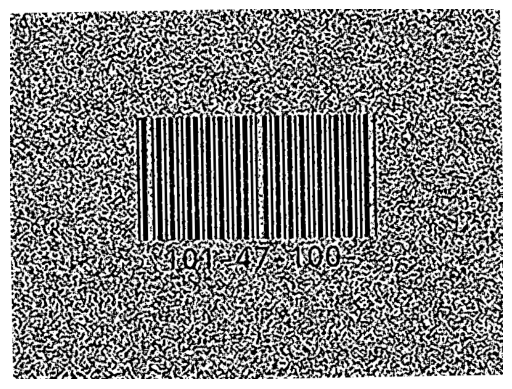

x: 166, y: 156, w: 470, h: 231


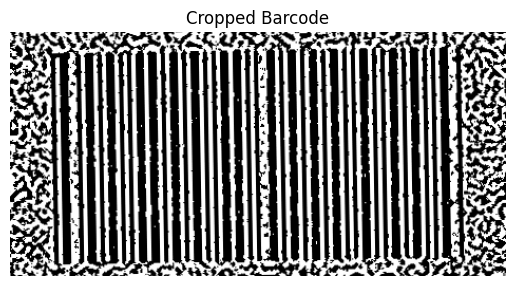

In [677]:
image_path = "/content/07 - mal7 w felfel.jpg"
image = cv2.imread(image_path)
def adaptive_thresholding(image, block_size=15, C=2):

    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian adaptive thresholding
    thresholded_image = cv2.adaptiveThreshold(image, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                              thresholdType=cv2.THRESH_BINARY,  blockSize=block_size, C=C)

    plt.imshow(thresholded_image, cmap='gray')
    plt.title('Adaptive Thresholded Img')
    plt.axis('off')
    plt.show()

    return thresholded_image


threshold1 = adaptive_thresholding(image)

def preprocessing(image):
    # Apply Gaussian blur

    gaussian_blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply median blur
    median_blurred = cv2.medianBlur(gaussian_blurred, 5)

    # CLAHE (Contrast Limited Adaptive Histogram Equalization) helpful in low contrast images
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    equalized = clahe.apply(median_blurred)

    # Adaptive Thresholding
    thresholded = cv2.adaptiveThreshold(
        equalized, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 1
    )

    plt.imshow(thresholded, cmap='gray')
    plt.title('Thresholded Image')
    plt.axis('off')
    plt.show()

    return thresholded


result = preprocessing(threshold1)
print(result)
def extract_barcode_region(image):
    # Convert to grayscale
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    _, binary = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    #shwyt morphological operations to clean noise and connect barcode
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (10, 50))
    cleaned = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)

    #find contours to get bounding box of the barcode
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        barcode_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(barcode_contour)
        return (x, y, w, h)
    return None
#this rotates pic 09 but fail with pic 11
def rotate_barcode_only(image):

    barcode_box = extract_barcode_region(image)
    if barcode_box:
        x, y, w, h = barcode_box

        # Crop the barcode region
        barcode_region = image[y:y+h, x:x+w]

        # Correct rotation using Hough transform
        #gray = cv2.cvtColor(barcode_region, cv2.COLOR_BGR2GRAY)
        edges = cv2.Canny(barcode_region, 50, 150, apertureSize=3)
        lines = cv2.HoughLines(edges, 1, np.pi / 180, 150)

        if lines is not None:
            angles = []
            for rho, theta in lines[:, 0]:
                angle = np.degrees(theta)
                if angle > 90:
                    angle -= 180
                angles.append(angle)

            #calc the rotation angle
            target_angle = np.median(np.array(angles))
            rotation_angle = target_angle - 90 if target_angle > 45 else target_angle

            #rotate
            h, w = barcode_region.shape[:2]
            center = (w // 2, h // 2)
            rot_matrix = cv2.getRotationMatrix2D(center, rotation_angle, 1.0)
            rotated_barcode = cv2.warpAffine(barcode_region, rot_matrix, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))
            #copy baa el rotated makan el original imaaaaaaaaaaage
            new_image = image.copy()
            new_image[y:y+h, x:x+w] = rotated_barcode
            return new_image
    return image

image = cv2.imread(image_path)
result_image = rotate_barcode_only(result) #nbasy el result mn l preprocessing
#print(result_image)
plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

#output_image_path = "10 - wen el kontraastttt.jpg" #saving ashan fl decode el gy
#cv2.imwrite(output_image_path, result_image)
def crop_tightly_barcode(image_path):
    import cv2
    import matplotlib.pyplot as plt

    TOLERANCE=40        #tolerance for contours

    # Apply binary thresholding (inverse binary + Otsu's method)
    _, binary = cv2.threshold(image_path, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    # Find external contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out vertical lines based on aspect ratio and position
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = h / w
        if aspect_ratio > 5 and x < binary.shape[1] * 0.1:  # Adjust the threshold as needed
            cv2.drawContours(binary, [contour], -1, 0, -1)  # Fill the unwanted contour with black

    # Clean up small noise and ensure only the barcode is isolated
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 50))
    binary_cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel)

    # Get a tight bounding box around the barcode
    x, y, w, h = cv2.boundingRect(binary_cleaned)


    print(f"x: {x-TOLERANCE}, y: {y}, w: {w+2*TOLERANCE}, h: {h}")

    # Crop the barcode based on the bounding box
    cropped = image_path[y:y + h, x-TOLERANCE:x + w+TOLERANCE]


    plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("Cropped Barcode")
    plt.show()

    return cropped


cropped = crop_tightly_barcode(result_image)




In [680]:

image_normalized = cv2.normalize(cropped, None, 0, 255, cv2.NORM_MINMAX).astype('uint8')

kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 17))
dilated = cv2.dilate(image_normalized, kernel, iterations=1)
closed = cv2.morphologyEx(dilated, cv2.MORPH_CLOSE, kernel)
eroded2 = cv2.erode(closed, kernel, iterations=1)
closed2=cv2.morphologyEx(eroded2, cv2.MORPH_CLOSE, kernel)
eroded3=cv2.erode(closed2, kernel, iterations=7)
dilation2 =cv2.dilate(eroded3, kernel, iterations=7)

# Plot all results
# plt.figure(figsize=(15, 10))

# plt.subplot(2, 3, 6), plt.title("Dilated 2 Image"), plt.imshow(dilation2, cmap='gray')
# plt.subplot(2, 3, 2), plt.title("Closed Image"), plt.imshow(closed, cmap='gray')
# plt.subplot(2, 3, 4), plt.title("Closed 2 Image"), plt.imshow(closed2, cmap='gray')
# plt.subplot(2, 3, 5), plt.title("Eroded 3 Image"), plt.imshow(eroded3, cmap='gray')
# plt.subplot(2, 3, 1), plt.title("Dilated Image"), plt.imshow(dilated, cmap='gray')
# plt.subplot(2, 3, 3), plt.title("eroded 2"), plt.imshow(eroded2, cmap='gray')
# plt.show()

In [681]:
# 0 means narrow, 1 means wide
NARROW = "0"
WIDE = "1"
code11_widths = {
    "00110": "Stop/Start",
    "10001": "1",
    "01001": "2",
    "11000": "3",
    "00101": "4",
    "10100": "5",
    "01100": "6",
    "00011": "7",
    "10010": "8",
    "10000": "9",
    "00001": "0",
    "00100": "-",
}

# Get the average of each column in your image
mean = dilation2.mean(axis=0)


# Set it to black or white based on its value
mean[mean <= 127] = 1
mean[mean > 128] = 0

# Convert to string of pixels in order to loop over it
pixels = ''.join(mean.astype(np.uint8).astype(str))

# Need to figure out how many pixels represent a narrow bar
narrow_bar_size = 0
flag=0
i=0
for pixel in pixels:
    if pixel == "1":
        narrow_bar_size += 1
        flag=1
    elif (flag==0): #haven't found first "1" yet
        i+=1
        continue
    else:
        break

wide_bar_size = narrow_bar_size * 2
#print("bat size:" , wide_bar_size)
# Decoding variables
digits = []
pixel_index = i
print("pixel index is:", pixel_index)
current_digit_widths = ""
skip_next = False

# Decoding logic
while pixel_index < len(pixels):
    if skip_next:

        pixel_index += narrow_bar_size
        skip_next = False
        continue

    count = 1
    try:
        while pixel_index + count < len(pixels) and pixels[pixel_index] == pixels[pixel_index + count]:
            count += 1
    except IndexError:
        pass


    pixel_index += count

    # Classify as narrow or wide
    if abs(count - narrow_bar_size) <= 1:  # Allow some tolerance
        current_digit_widths += NARROW
    elif abs(count - wide_bar_size) <= 2:
        current_digit_widths += WIDE
    else:

        print(f"Unrecognized bar size at pixel: {pixel_index}, width: {count}")
        current_digit_widths = ""
        continue

    # Match the current sequence to a digit
    if current_digit_widths in code11_widths:
        matched_digit = code11_widths[current_digit_widths]
        digits.append(matched_digit)
        print(f"Matched with: {matched_digit}, sequence: {current_digit_widths}")
        current_digit_widths = ""
        skip_next = True  # Prepare to skip the separator
print(pixels)
# Print the final output
print(f"Decoded barcode: {digits}")


pixel index is: 40
Matched with: Stop/Start, sequence: 00110
Unrecognized bar size at pixel: 73, width: 1
Matched with: 1, sequence: 10001
Matched with: 0, sequence: 00001
Unrecognized bar size at pixel: 133, width: 1
Unrecognized bar size at pixel: 145, width: 1
Unrecognized bar size at pixel: 146, width: 1
Unrecognized bar size at pixel: 147, width: 1
Matched with: -, sequence: 00100
Unrecognized bar size at pixel: 175, width: 1
Unrecognized bar size at pixel: 195, width: 1
Unrecognized bar size at pixel: 196, width: 1
Unrecognized bar size at pixel: 197, width: 1
Matched with: 4, sequence: 00101
Unrecognized bar size at pixel: 229, width: 1
Unrecognized bar size at pixel: 230, width: 1
Unrecognized bar size at pixel: 231, width: 1
Matched with: 7, sequence: 00011
Unrecognized bar size at pixel: 263, width: 1
Unrecognized bar size at pixel: 264, width: 1
Unrecognized bar size at pixel: 265, width: 1
Matched with: -, sequence: 00100
Unrecognized bar size at pixel: 295, width: 2
Unreco